In [32]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
# plt.style.use('fivethirtyeight')

In [33]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [34]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(chris_path)
    print(king_all_copy)

            date  king
0     1938-05-01   201
1     1938-05-02   227
2     1938-05-03    78
3     1938-05-04    37
4     1938-05-05    29
...          ...   ...
24729 2021-04-28  2433
24730 2021-04-29  4782
24731 2021-04-30  4641
24732 2021-05-01  2087
24733 2021-05-02  2517

[24734 rows x 2 columns]
            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [79]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
    king_test[king_test["king"] < 0] = 0
    king_train_pre = king_training["king"].to_frame()
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)
    
    # Create list
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
    
    
    for i in range(180,22545): # 30
        x_train.append(king_train_norm[i-180:i])
        y_train.append(king_train_norm[i])
    for i in range(180, 1824):
        x_test.append(king_test_norm[i-180:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm for testing 
    for i in range(180, 1824):
        y_test_not_norm.append(king_test['king'][i])
    for i in range(180,22545): # 30
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [80]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(king_all_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1])).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]))
y_train = np.array(y_train)
y_test = np.array(y_test)

# create non-norm for testing 
y_test_not_norm = np.array(y_test_not_norm)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))


(1824, 2)
max val king_train:
67521
max val king_test:
32446
(1824, 1)
(22365, 180)


In [38]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    

In [39]:
def create_linear_model(x_train, y_train, x_test, y_test, scaler): 
    '''
    creating a basic linear regression model
    '''
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    train_preds_lr = lr.predict(x_train)
    test_preds_lr = lr.predict(x_test)
    
    #Descale 
    
    train_preds_lr = scaler.inverse_transform(train_preds_lr)
    y_train = scaler.inverse_transform(y_train)
    test_preds_lr = scaler.inverse_transform(test_preds_lr)
    test_preds_lr = test_preds_lr.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)
    
    return train_preds_lr, test_preds_lr, y_train, y_test

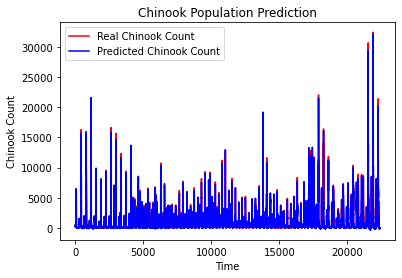

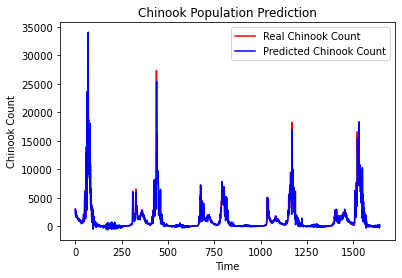

The root mean squared error is 520.1790974814926.
The root mean squared error is 1417.723457843492.


In [40]:
lr_train, lr_test, y_train, y_test = create_linear_model(x_train, y_train, x_test, y_test, scaler)

plot_predictions(y_train, lr_train)
plot_predictions(y_test, lr_test)
return_rmse(y_train, lr_train)
return_rmse(y_test, lr_test)

In [20]:
def create_RR_model(x_train, y_train, x_test, y_test, scaler): 
    '''
    creating a basic Ridge Regression model (L2)
    '''
    rr = Ridge(alpha=0.1)
    rr.fit(x_train, y_train)
    train_preds_rr = rr.predict(x_train)
    test_preds_rr = rr.predict(x_test)
    print(train_preds_rr.shape)
    
    #Descale 
    
    train_preds_rr = scaler.inverse_transform(train_preds_rr)
    y_train = scaler.inverse_transform(y_train)
    test_preds_rr = scaler.inverse_transform(test_preds_rr)
    test_preds_rr = test_preds_rr.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)
    
    return train_preds_rr, test_preds_rr, y_train, y_test

(22365, 1)


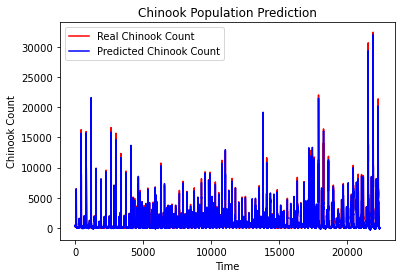

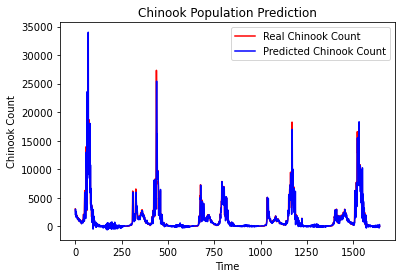

The root mean squared error is 520.1806099907122.
The root mean squared error is 1416.4716271206973.


In [21]:
rr_train, rr_test, y_train, y_test = create_RR_model(x_train, y_train, x_test, y_test, scaler)

plot_predictions(y_train, rr_train)
plot_predictions(y_test, rr_test)
return_rmse(y_train, rr_train)
return_rmse(y_test, rr_test)

In [81]:
def create_lasso(x_train, y_train, x_test, y_test, scaler): 
    '''
    creating lasso regression (L1)
    '''
    lasso = Lasso(alpha=0.0001)
    lasso.fit(x_train, y_train)
    train_preds_lasso = lasso.predict(x_train)
    print(train_preds_lasso)
    test_preds_lasso = lasso.predict(x_test)
    print(train_preds_lasso.shape)
    train_preds_lasso = train_preds_lasso.reshape(train_preds_lasso.shape[0], 1)
    test_preds_lasso = test_preds_lasso.reshape(test_preds_lasso.shape[0], 1)
    #Descale 
    
    train_preds_lasso = scaler.inverse_transform(train_preds_lasso)
    y_train = scaler.inverse_transform(y_train)
    test_preds_lasso = scaler.inverse_transform(test_preds_lasso)
    test_preds_lasso = test_preds_lasso.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)

    
    return train_preds_lasso, test_preds_lasso, y_train, y_test 

[0.00835204 0.00929928 0.00851214 ... 0.00212162 0.00212162 0.00213496]
(22365,)


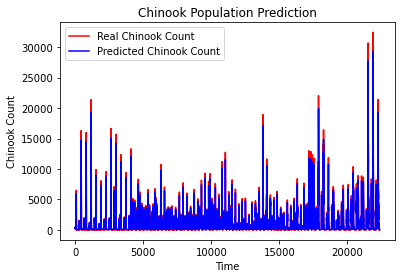

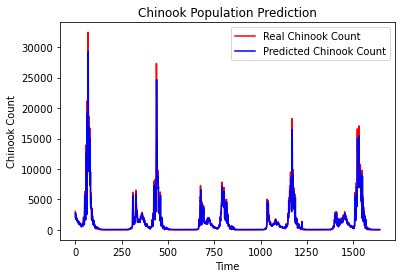

The root mean squared error is 538.4020947589681.
The root mean squared error is 1356.7620677164293.


In [82]:
lasso_train, lasso_test, y_train, y_test = create_lasso(x_train, y_train, x_test, y_test, scaler)

plot_predictions(y_train, lasso_train)
plot_predictions(y_test, lasso_test)
return_rmse(y_train, lasso_train)
return_rmse(y_test, lasso_test)